In [2]:
#Importing libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn.datasets import make_spd_matrix
from sklearn import datasets
from sklearn import preprocessing
from sklearn.metrics import classification_report

In [139]:
#Code from the appendix

#To sample from a mixture of Gaussians
def genGaussianSamples(N, m, C):
    A = np.linalg.cholesky(C)
    U = np.random.randn(N,2)
    return(U @ A.T + m)

#Code to plot graphs, pulled from my previous labs (lab3)
def gauss2D(x, m, C):
    Ci = np.linalg.inv(C)
    dC = np.linalg.det(Ci)
    num = np.exp(-0.5 * np.dot((x-m).T, np.dot(Ci, (x-m))))
    den = 2 * np.pi * dC
    
    return num/den

def twoDGaussianPlot (nx, ny, m, C):
    x = np.linspace(-7, 7, nx)
    y = np.linspace(-7, 7, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    Z = np.zeros([nx, ny])
    for i in range(nx):
        for j in range(ny):
            xvec = np.array([X[i,j], Y[i,j]])
            Z[i,j] = gauss2D(xvec, m, C)
            
    return X, Y, Z

# Define three means
Means = np.array([[0, 3], [3, 0], [4,4]])

# Define three covariance matrices ensuring they are positive definite
CovMatrices = np.zeros((3,2,2))
for j in range(3):
    CovMatrices[j,:,:] = make_spd_matrix(2)

# Priors
w = np.random.rand(3)
w = w / np.sum(w)

# How many data in each component (1000 in total)
nData = np.floor(w * 1000).astype(int)

# Draw samples from each component
X0 = genGaussianSamples(nData[0], Means[0,:], CovMatrices[0,:,:])
X1 = genGaussianSamples(nData[1], Means[1,:], CovMatrices[1,:,:])
X2 = genGaussianSamples(nData[2], Means[2,:], CovMatrices[2,:,:])

# Append into an array for the data we need
X = np.append(np.append(X0, X1, axis=0), X2, axis=0)

#print(X) #This is the sample data from the mixture of gaussian densities

#Code for the K−means iterations
#Number of clusters
K=3

def kmean_clustering(data, K, ax): 
    num_data = data.shape[0]
    distance_to_m = np.zeros((num_data, K))
    #initialising the cluster centers
    cluster = np.zeros(num_data)
    cluster_centers = data[np.random.randint(0, num_data, size = K),:] 
    
    while True:
        #To track the estimates of each iteration
        for i in range(K):
            ax.scatter(cluster_centers[i,0], cluster_centers[i,1], c='b', s=20, alpha=0.75)
        
        new_cluster = np.zeros(num_data)
        for i in range(num_data):
            for j in range(K):
                distance_to_m[i,j] = np.linalg.norm(data[i,:] - cluster_centers[j,:])
                new_cluster[i] = np.argmin(distance_to_m[i,:])
        if np.array_equal(cluster, new_cluster):
            break
        else:
            cluster = new_cluster
            for i in range(K):
                cluster_members = data[np.argwhere(cluster == i)]
                if(cluster_members.size > 0):
                    new_m = np.mean(cluster_members, 0)
                    cluster_centers[i,:] = new_m
    return cluster_centers

<Figure size 432x288 with 0 Axes>

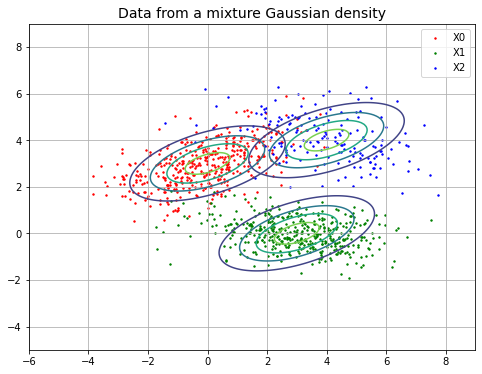

In [140]:
#Plotting the graph of data from a mixture Gaussian density
fig = plt.figure()
plt.subplots(figsize=(8,6))
plt.xlim([-6, 9])
plt.ylim([-5, 9])

plt.scatter(X0[:,0], X0[:,1], c='r', s=2)
plt.scatter(X1[:,0], X1[:,1], c='g', s=2)
plt.scatter(X2[:,0], X2[:,1], c='b', s=2)

cX, cY, cZ = twoDGaussianPlot(nData[0], nData[0], Means[0,:], CovMatrices[0,:,:])
plt.contour(cX, cY, cZ, 4)
cX, cY, cZ = twoDGaussianPlot(nData[1], nData[1], Means[1,:], CovMatrices[0,:,:])
plt.contour(cX, cY, cZ, 4)
cX, cY, cZ = twoDGaussianPlot(nData[2], nData[2], Means[2,:], CovMatrices[0,:,:])
plt.contour(cX, cY, cZ, 4)

plt.title('Data from a mixture Gaussian density', fontsize=14)
plt.grid(True)
plt.gca().legend(('X0','X1','X2'))
plt.savefig('gaussianSamples.png')


[[-0.49393493  2.60925658]
 [ 3.24968657 -0.05701519]
 [ 3.4599666   4.05718001]]
[[-0.49393493  2.60925658]
 [ 3.4599666   4.05718001]
 [ 3.24968657 -0.05701519]]


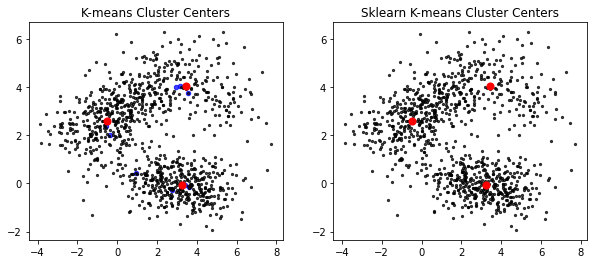

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

#using k-means clustering algorithm
kmcenters = kmean_clustering(X, K, ax[0])

ax[0].set_title('K-means Cluster Centers')
ax[0].scatter(X[:,0], X[:,1], s=5, c='black', alpha=0.75)
ax[0].scatter(kmcenters[:,0], kmcenters[:,1], s=50, c='r')

#using the sklearn k-means clustering agorithm
#initialising the data and using our smaple dataset to get the cluster centers
sklcenters = KMeans(n_clusters=K).fit(X).cluster_centers_ 

ax[1].set_title('Sklearn K-means Cluster Centers')
ax[1].scatter(X[:,0], X[:,1], s=5, c='black', alpha=0.75)
ax[1].scatter(sklcenters[:,0], sklcenters[:,1], s=50, c='r')

print(kmcenters)
print(sklcenters)
#The results are identical!!

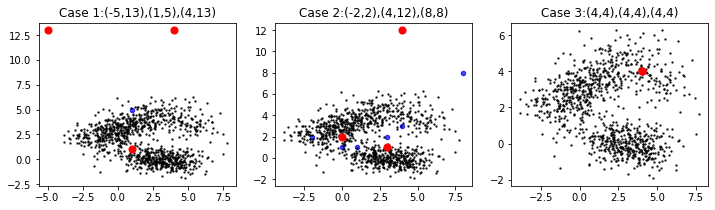

In [146]:
#Analysing the effectiveness on the initial guess of the clusters
def tkmean_clustering(data, K, ax, cluster_centers): 
    num_data = data.shape[0]
    distance_to_m = np.zeros((num_data, K))
    cluster = np.zeros(num_data)
    while True:
        for i in range(K):
            ax.scatter(cluster_centers[i,0], cluster_centers[i,1], c='b', s=20, alpha=0.75)
        
        new_cluster = np.zeros(num_data)
        for i in range(num_data):
            for j in range(K):
                distance_to_m[i,j] = np.linalg.norm(data[i,:] - cluster_centers[j,:])
                new_cluster[i] = np.argmin(distance_to_m[i,:])
        if np.array_equal(cluster, new_cluster):
            break
        else:
            cluster = new_cluster
            for i in range(K):
                cluster_members = data[np.argwhere(cluster == i)]
                if(cluster_members.size > 0):
                    new_m = np.mean(cluster_members, 0)
                    cluster_centers[i,:] = new_m
    return cluster_centers

#Have to change the initial cluster centers
#Chage parameter in the kmean_clustering function

#Analysing the effects on the parameter K
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

#case 1
tmcenters1 = tkmean_clustering(X, K, ax[0], np.array([[-5,13], [1, 5], [4,13]]))
ax[0].set_title('Case 1:(-5,13),(1,5),(4,13)')
ax[0].scatter(X[:,0], X[:,1], s=2, c='black', alpha=0.75)
ax[0].scatter(tmcenters1[:,0], tmcenters1[:,1], s=50, c='r')

#case 2
tmcenters2 = tkmean_clustering(X, K, ax[1], np.array([[-2,2], [4,12], [8,8]]))
ax[1].set_title('Case 2:(-2,2),(4,12),(8,8)')
ax[1].scatter(X[:,0], X[:,1], s=2, c='black', alpha=0.75)
ax[1].scatter(tmcenters2[:,0], tmcenters2[:,1], s=50, c='r')

#case 3
tmcenters3 = tkmean_clustering(X, K, ax[2], np.array([[4,4], [4,4], [4,4]]))
ax[2].set_title('Case 3:(4,4),(4,4),(4,4)')
ax[2].scatter(X[:,0], X[:,1], s=2, c='black', alpha=0.75)
ax[2].scatter(tmcenters3[:,0], tmcenters3[:,1], s=50, c='r')

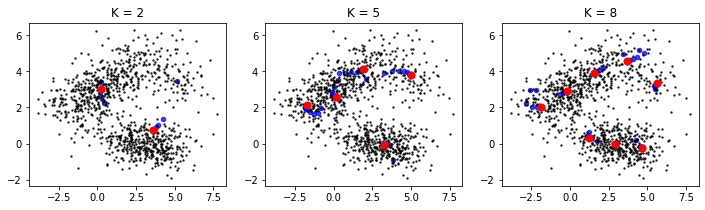

In [143]:
#Analysing the effects on the parameter K
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

#K=2
kmcenters2 = kmean_clustering(X, 2, ax[0])
ax[0].set_title('K = 2')
ax[0].scatter(X[:,0], X[:,1], s=2, c='black', alpha=0.75)
ax[0].scatter(kmcenters2[:,0], kmcenters2[:,1], s=50, c='r')

#K=5
kmcenters5 = kmean_clustering(X, 5, ax[1])
ax[1].set_title('K = 5')
ax[1].scatter(X[:,0], X[:,1], s=2, c='black', alpha=0.75)
ax[1].scatter(kmcenters5[:,0], kmcenters5[:,1], s=50, c='r')

#K=8
kmcenters8 = kmean_clustering(X, 8, ax[2])
ax[2].set_title('K = 8')
ax[2].scatter(X[:,0], X[:,1], s=2, c='black', alpha=0.75)
ax[2].scatter(kmcenters8[:,0], kmcenters8[:,1], s=50, c='r')

<Figure size 432x288 with 0 Axes>

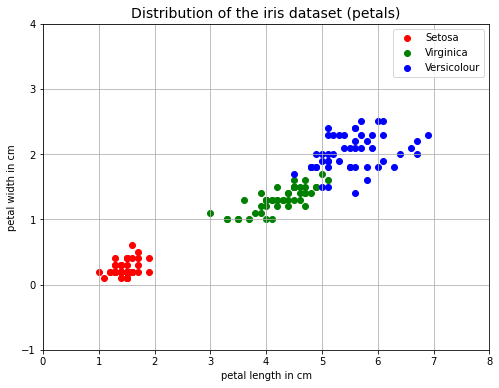

In [150]:
#adding the column names, for ease in manipulating the data too
#experiment and see which features should be chosen to improve the algorithm's accuracy
#decide to use x=petal length and y=petal width
iris_name = ['sepal length in cm','sepal width in cm', 'petal length in cm', 'petal width in cm', 'class']
iris_data = pd.read_csv(r"C:.\iris.data", usecols = [2,3], names=iris_name)


#print(iris_data)

#seperating the data into their classes
#the data was already nicely ordered :)
#setosa
ids = iris_data[:50]
#virginica
idvi = iris_data[50:100]
#versicolour
idve = iris_data[100:150]
#print(ids)
#print(idvi)
#print(idve)

#print(ids['petal length in cm'])
#Making a plot to show the distirbution of the dataset
fig = plt.figure()
plt.subplots(figsize=(8,6))
plt.xlim([0, 8])
plt.ylim([-1, 4])

plt.scatter(ids['petal length in cm'], ids['petal width in cm'], c='r')
plt.scatter(idvi['petal length in cm'], idvi['petal width in cm'], c='g')
plt.scatter(idve['petal length in cm'], idve['petal width in cm'], c='b')

plt.title('Distribution of the iris dataset (petals)', fontsize=14)
plt.grid(True)
plt.gca().legend(('Setosa','Virginica','Versicolour'))
plt.xlabel('petal length in cm')
plt.ylabel('petal width in cm')
plt.savefig('irisdistr.png')




Text(0, 0.5, 'petal width in cm')

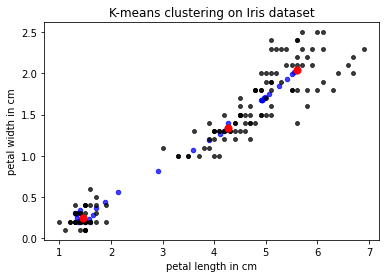

In [126]:
#Have to turn the pandas data frame to a numpy array for it to be passed to my 
#Should have done this earlier
kiris_data = iris_data.to_numpy()

#Plot to show the clusters
fig, ax = plt.subplots()
kmcenters = kmean_clustering(kiris_data, 3, ax) #Number of clusters is 3 as it is specified that there are 3 classes
ax.set_title('K-means clustering on Iris dataset')
ax.scatter(kiris_data[:,0], kiris_data[:,1], s=15, c='black', alpha=0.75)
ax.scatter(kmcenters[:,0], kmcenters[:,1], s=50, c='r')
ax.set_xlabel('petal length in cm')
ax.set_ylabel('petal width in cm')

<Figure size 432x288 with 0 Axes>

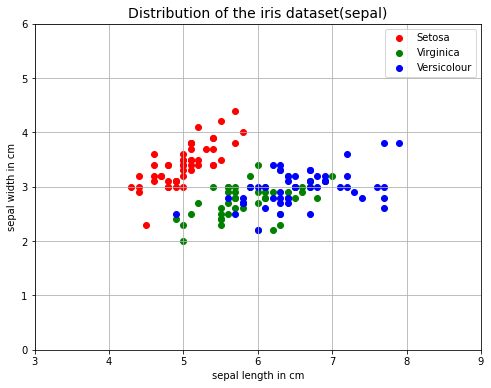

In [151]:
#Same thing but for sepal length and sepal width
#! way more difficult to cluster!! esp 'Virginica','Versicolour' compared to using petal dimensions
iris_name = ['sepal length in cm','sepal width in cm', 'petal length in cm', 'petal width in cm', 'class']
iris_data = pd.read_csv(r"C:.\iris.data", usecols = [0,1], names=iris_name)
#print(iris_data)

#seperating the data into their classes
#the data was already nicely ordered :)
#setosa
ids = iris_data[:50]
#virginica
idvi = iris_data[50:100]
#versicolour
idve = iris_data[100:150]
#print(ids)
#print(idvi)
#print(idve)

#print(ids['petal length in cm'])
#Making a plot to show the distirbution of the dataset
fig = plt.figure()
plt.subplots(figsize=(8,6))
plt.xlim([3, 9])
plt.ylim([0, 6])

plt.scatter(ids['sepal length in cm'], ids['sepal width in cm'], c='r')
plt.scatter(idvi['sepal length in cm'], idvi['sepal width in cm'], c='g')
plt.scatter(idve['sepal length in cm'], idve['sepal width in cm'], c='b')

plt.title('Distribution of the iris dataset(sepal)', fontsize=14)
plt.grid(True)
plt.gca().legend(('Setosa','Virginica','Versicolour'))
plt.xlabel('sepal length in cm')
plt.ylabel('sepal width in cm')
plt.savefig('irisdistr.png')

Text(0, 0.5, 'sepal width in cm')

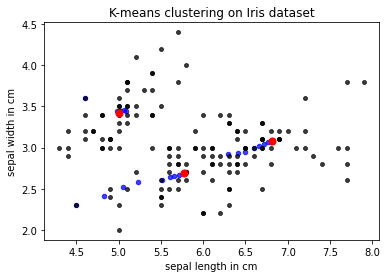

In [128]:
#Have to turn the pandas data frame to a numpy array for it to be passed to my algorithm
kiris_data = iris_data.to_numpy()

#Plot to show the clusters
fig, ax = plt.subplots()
kmcenters = kmean_clustering(kiris_data, 3, ax) #Number of clusters is 3 as it is specified that there are 3 classes
ax.set_title('K-means clustering on Iris dataset')
ax.scatter(kiris_data[:,0], kiris_data[:,1], s=15, c='black', alpha=0.75)
ax.scatter(kmcenters[:,0], kmcenters[:,1], s=50, c='r')
ax.set_xlabel('sepal length in cm')
ax.set_ylabel('sepal width in cm')

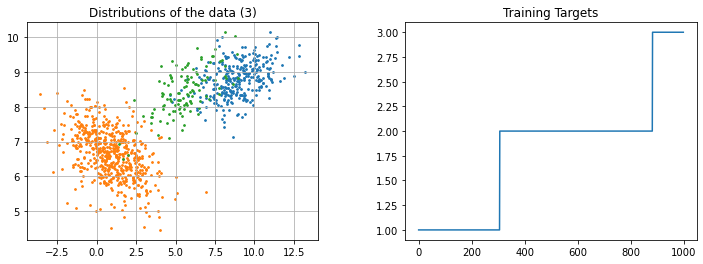

In [216]:
#Code snippet from appendix:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#To generate a difficult classification problem where 20% of the data overlap I need to manually set 
#the gaussian where the means are closer together


def genGaussianSamples(N, m, C):
    A = np.linalg.cholesky(C)
    U = np.random.randn(N,2)
    return(U @ A.T + m)

NClasses = 3

# Priors
#
w = np.random.rand(NClasses)
w = w / np.sum(w)
N = 1000 # total data (Training = Test)
NPrior = np.floor(w * N).astype(int)

Scale = 10
Means = Scale*np.random.rand(NClasses, 2)

#Means = [[2,1],[2,2],[4,5]]

from sklearn.datasets import make_spd_matrix
CovMatrices = np.zeros((NClasses,2,2))
for j in range(NClasses):
    CovMatrices[j,:,:] = make_spd_matrix(2)
    
# total data (Training = Test)
Data_All=list()
for j in range(NClasses):
    Data_All.append(genGaussianSamples(NPrior[j], Means[j,:], CovMatrices[j,:,:])) 

#AllData_train = list()
#for j in range(NClasses):
#    AllData_train.append(genGaussianSamples(NPrior[j], Means[j,:], CovMatrices[j,:,:]))

X = Data_All[0]
y = np.ones((NPrior[0], 1)) 
for j in range(NClasses-1):
    Xj = genGaussianSamples(NPrior[j+1], Means[j+1,:], CovMatrices[j+1,:,:])
    X = np.append(X, Xj, axis=0)
    yj = (j+2)*np.ones((NPrior[j+1], 1))
    y = np.append(y, yj)

#X_train = AllData_train[0]
#y_train = np.ones((NPrior[0], 1))
#for j in range(NClasses-1):
#    Xj = genGaussianSamples(NPrior[j+1], Means[j+1,:], CovMatrices[j+1,:,:])
#    X_train = np.append(X_train, Xj, axis=0)
#    yj = (j+2)*np.ones((NPrior[j+1], 1))
#    y_train = np.append(y_train, yj)

#AllData_test = list()
#for j in range(NClasses):
#    AllData_test.append(genGaussianSamples(NPrior[j], Means[j,:], CovMatrices[j,:,:]))

#X_test = AllData_test[0]
#y_test = np.ones((NPrior[0], 1))
#for j in range(NClasses-1):
#    Xj = genGaussianSamples(NPrior[j+1], Means[j+1,:], CovMatrices[j+1,:,:])
#    X_test = np.append(X_test, Xj, axis=0)
#    yj = (j+2)*np.ones((NPrior[j+1], 1))
#    y_test = np.append(y_test, yj)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4)) 
plt.subplots_adjust(wspace=0.3) 
for j in range(NClasses):
    Xplt = Data_All[j]
    ax[0].scatter(Xplt[:,0], Xplt[:,1], s=3) 
ax[0].grid(True) 
ax[0].set_title("Distributions of the data (3)") 

ax[1].plot(y) 
ax[1].set_title("Training Targets") 

plt.savefig("Task3Distributions.png")

#fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
#plt.subplots_adjust(wspace=0.3)
#for j in range(NClasses):
#    Xplt = AllData_train[j]
#    ax[0].scatter(Xplt[:,0], Xplt[:,1], s=3)
#ax[0].grid(True)
#ax[0].set_title("Training Data Distributions")

#ax[1].plot(y_train)
#ax[1].set_title("Training Targets")

#for j in range(NClasses):
#    Xplt = AllData_test[j]
#    ax[2].scatter(Xplt[:,0], Xplt[:,1], s=3)
#ax[2].grid(True)
#ax[2].set_title("Test Data Distributions")

Accuracy at fold 0 : 0.93
Accuracy at fold 1 : 0.91
Accuracy at fold 2 : 0.93
Accuracy at fold 3 : 1.0
Accuracy at fold 4 : 1.0
Accuracy at fold 5 : 1.0
Accuracy at fold 6 : 1.0
Accuracy at fold 7 : 1.0
Accuracy at fold 8 : 0.95
Accuracy at fold 9 : 0.5050505050505051


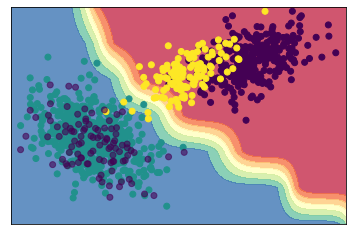

In [217]:
#10-fold cross validation for Bayesian classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from matplotlib.colors import ListedColormap

kf = KFold(n_splits=10)
error_train=[]
error_test=[]
bayes_accuracy = np.array([])
i=0


for train_index, test_index in kf.split(X):
        
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    # Training a Bayesian classifier from sklearn
    Bysnclf = GaussianNB()
    Bysnclf.fit(X_train, y_train)
    
    # Predictions, accuracy and confusion matrix 
    pred_train = Bysnclf.predict(X_train)
    pred_test = Bysnclf.predict(X_test)
    score = accuracy_score(y_test, pred_test)
    bayes_accuracy = np.append(bayes_accuracy, score)
    
    i=i+1
    print('Accuracy at fold', i, ':', score)

    
    #choose a round to generate class boundaries plot
    if i==8:
        x_min,x_max = X[:,0].min()-0.5,X[:,0].max()+0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx,yy = np.meshgrid(np.arange(x_min,x_max,0.02),np.arange(y_min,y_max))
        Z=Bysnclf.predict_proba(np.c_[xx.ravel(),yy.ravel()])[:,1]
        Z=Z.reshape(xx.shape)
        
        plt.contourf(xx,yy,Z,cmap = plt.cm.Spectral,alpha = 0.8)
        plt.scatter(X_train[:,0],X_train[:,1],c = y_train)
        plt.scatter(X_test[:,0],X_test[:,1],c = y_test,alpha = 0.6)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())

plt.savefig("BayesPlot.png")

Accuracy at fold 0 : 0.89
Accuracy at fold 1 : 0.91
Accuracy at fold 2 : 0.93
Accuracy at fold 3 : 0.88
Accuracy at fold 4 : 0.96
Accuracy at fold 5 : 0.87
Accuracy at fold 6 : 0.92
Accuracy at fold 7 : 0.94
Accuracy at fold 8 : 0.8
Accuracy at fold 9 : 0.0
Confusion Matrix: 
[[302   4   0]
 [ 16 560   0]
 [ 14   4   0]]


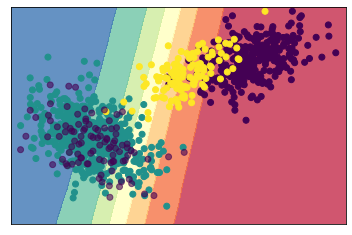

In [225]:
###Approximating Bayes Posterior: MLP Training### 
#10 fold cross validation
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

kf = KFold(n_splits=10)
MLP_accuracy=np.array([])
i=0

for train_index, test_index in kf.split(X):
    
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    #(code from appendix)
    # Encoding the output
    #
    onehot_encoder = OneHotEncoder(sparse=False)
    y_onehot_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
    
    #y_test(one hot encoder)
    n=0
    y_onehot_test = np.zeros((y_test.shape[0], 3))
    for k in y_test:
        if k==1:
            y_onehot_test[n,:]=[1, 0, 0]
        if k==2:
            y_onehot_test[n,:]=[0, 1, 0]
        if k==3:
            y_onehot_test[n,:]=[0, 0, 1]
        n+=1

    # Trainign a neural network
    #
    #clf = MLPClassifier(hidden_layer_sizes=(300,), max_iter=600)
    #clf = MLPClassifier(hidden_layer_sizes=(10))
    clf = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=True, 
                        epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001, 
                        max_iter=200, momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=None, shuffle=True, 
                        solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False, warm_start=False)
    
    clf.fit(X_train, y_onehot_train)

    # Predictions, accuracy and confusion matrix
    #
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    
    #print(accuracy_score(y_onehot_train, y_pred_train))
    score = accuracy_score(y_onehot_test, pred_test)
    MLP_accuracy = np.append(MLP_accuracy, score)
    
    N_train = X_train.shape[0]
    predicted_class_train = np.zeros((N_train,1)) 
    for j in range(N_train):
        predicted_class_train[j] = (1+np.argmax(pred_train[j,:])).astype(int)

    
    i = i+1
    print('Accuracy at fold', i, ':', score)

    #choose a round to generate class boundaries plot
    #
    if i==8:
        x_min,x_max = X[:,0].min()-0.5,X[:,0].max()+0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx,yy = np.meshgrid(np.arange(x_min,x_max,0.02),np.arange(y_min,y_max))
        Z = clf.predict_proba(np.c_[xx.ravel(),yy.ravel()])[:,1]
        Z=Z.reshape(xx.shape)
        
        plt.contourf(xx,yy,Z,cmap = plt.cm.Spectral,alpha = 0.8)
        plt.scatter(X_train[:,0],X_train[:,1],c = y_train)
        plt.scatter(X_test[:,0],X_test[:,1],c = y_test,alpha = 0.6)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())

print("Confusion Matrix: ")
print(confusion_matrix(y_train, predicted_class_train))

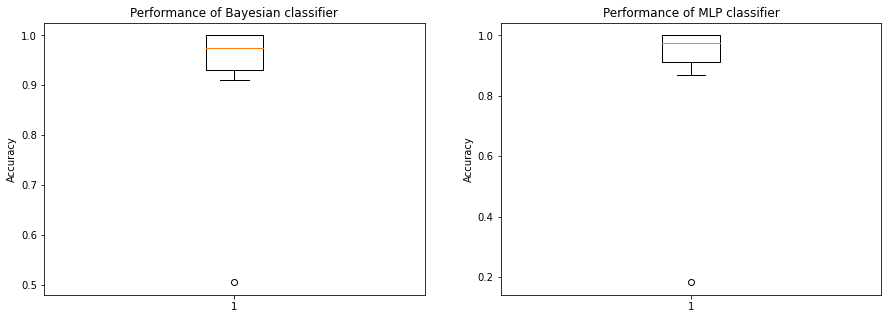

In [219]:
#Boxplots attained from 10-fold cross validation
#some code pulled from lab 5

fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].boxplot(bayes_accuracy)
ax[0].set_title("Performance of Bayesian classifier")
ax[0].set_ylabel("Accuracy")

ax[1].boxplot(MLP_accuracy)
ax[1].set_title("Performance of MLP classifier")
ax[1].set_ylabel("Accuracy")

plt.savefig("Bayesian and MLP boxplots.png")

In [202]:
MLPClassifier(activation='relu', 
              alpha=0.0001, 
              batch_size='auto', 
              beta_1=0.9, 
              beta_2=0.999, 
              early_stopping=False, 
              epsilon=1e-08, 
              hidden_layer_sizes=(100,), 
              learning_rate='constant', 
              learning_rate_init=0.001, 
              max_iter=200, 
              momentum=0.9, 
              nesterovs_momentum=True, 
              power_t=0.5, 
              random_state=None, 
              shuffle=True,
              solver='adam', 
              tol=0.0001, 
              validation_fraction=0.1, 
              verbose=False, 
              warm_start=False)

MLPClassifier()

(40, 10)
6.47895043165839e-15


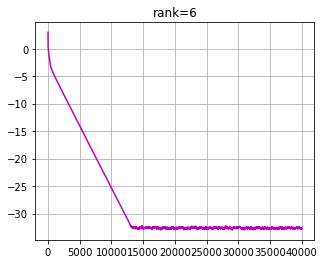

In [160]:
#Code from appendix
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Specify the rank
#
r = 6;

# Construct a low rank matrix
#
Wtrue = np.random.rand(40,5)
Htrue = np.random.rand(5,10)
V0 = Wtrue @ Htrue
print(V0.shape)

# Dimensions of data
#
m, n = V0.shape

# Normalise columnwise
#
V = np.zeros((m,n))
for i in range(n):
    V[:,i] = V0[:,i] / np.max(V0[:,i])

# Initialize
#
W = np.random.rand(m,r);
H = np.random.rand(r,n);

MaxIter = 40000
f = np.zeros((MaxIter,1))
# Initial error
#
f[0] = np.linalg.norm(V - W @ H, ord='fro');

for iter in range(MaxIter-1):
    # Update W
    #
    VH_T = V@H.T
    WHH_T =  W@H@H.T
    for i in range(np.size(W, 0)):
        for j in range(np.size(W, 1)):
            W[i, j] = W[i, j] * VH_T[i, j] / WHH_T[i, j]
    
    # Update H
    #
    W_TV = W.T@V
    W_TWH = W.T@W@H
    for i in range(np.size(H, 0)):
        for j in range(np.size(H, 1)):
            H[i, j] = H[i, j] * W_TV[i, j] / W_TWH[i, j]
            
    # Measure Error
    #
    f[iter+1] = np.linalg.norm(V - W @ H, ord='fro')

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(np.arange(MaxIter), np.log(f), c='m')
ax.grid(True)
ax.set_title('rank=6')
print(np.linalg.norm(V - W @ H, ord='fro'))


In [164]:
from sklearn.decomposition import NMF


r=14;

model = NMF(n_components=r, init='random', random_state=0)
#Learn a NMF model for the data V and returns the transformed data.
W = model.fit_transform(V)
H = model.components_
    
#could do a loop?
print(np.linalg.norm(V - W @ H, ord='fro'))


0.001660551674049063


In [226]:
#rank
r=10;

#loading the excel file using pandas
file = pd.read_excel(r'C:\Users\Brijee\Equities.xlsx')

#checking the sauce :)
#print(file)

#file = 

